In [77]:
import scanpy as sc
import pandas as pd
import gseapy as gp
from gseapy.plot import barplot, dotplot
import mygene
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [2]:
data_mat = h5py.File("datasets/ADT/CITESeq_GSE100866_anno.h5")

x1 = np.array(data_mat['X1'])
gene_name = np.array(data_mat['Genes'])
print(gene_name)
if isinstance(gene_name[0], bytes):
    gene_name = [name.decode('utf-8') for name in gene_name]
adata = sc.AnnData(x1)
adata
print(adata.obs)
adata.var_names = gene_name
print(adata.var_names)
clusters = pd.read_csv("./results/GSE100866/GSE100866_pred.csv",header =None)
print(clusters) 
len(clusters[0])
if len(clusters) != adata.n_obs:
    raise ValueError("clusters vector length does not match the number of cells in the AnnData object")

cell_type = np.array(data_mat['Celltypes'])
print(cell_type)
if isinstance(cell_type[0], bytes):
    cell_type = [name.decode('utf-8') for name in cell_type]
adata.obs['clusters'] = cell_type
adata.obs['clusters'] = adata.obs['clusters'].astype('category')


adata.obs['clusters']



[b'A1BG' b'A1BG-AS1' b'A1CF' ... b'ZYG11B' b'ZYX' b'ZZEF1']
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[1182 rows x 0 columns]
Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1',
       'A2ML1-AS2', 'A3GALT2', 'A4GALT',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=33514)
        0
0     4.0
1     0.0
2     3.0
3     4.0
4     3.0
...   ...
1177  1.0
1178  3.0
1179  4.0
1180  3.0
1181  4.0

[1182 rows x 1 columns]
[b'CD8+ T cells' b'B cells' b'CD4+ T cells' ... b'CD8+ T cells'
 b'CD4+ T 

0          CD8+ T cells
1               B cells
2          CD4+ T cells
3          CD8+ T cells
4          CD4+ T cells
             ...       
1177    CD14+ monocytes
1178       CD4+ T cells
1179       CD8+ T cells
1180       CD4+ T cells
1181       CD8+ T cells
Name: clusters, Length: 1182, dtype: category
Categories (6, object): ['B cells', 'CD14+ monocytes', 'CD16+ monocytes', 'CD4+ T cells', 'CD8+ T cells', 'NK cells']

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 1182 × 13182
    obs: 'clusters', 'n_genes'
    var: 'n_cells'

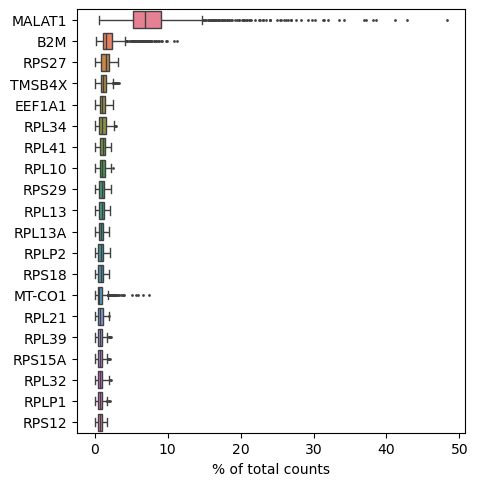

In [30]:
adata.obs['clusters']
sc.pl.highest_expr_genes(adata, n_top=20) # Average expression of each gene across all cells (percent content is calculated here)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [5]:
# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
print(adata.X[:5, :5])
print(np.isnan(adata.X).sum()) 

[[0.        0.        1.5806319 0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        1.523744  0.       ]]
0


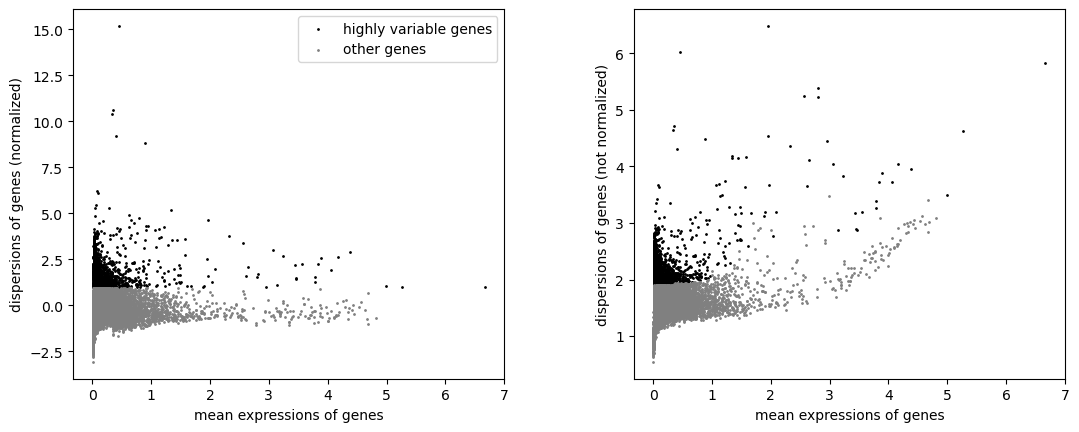

         Falling back to preprocessing with `sc.pp.pca` and default params.


D:\Anaconda\Lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [6]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
adata.raw = adata
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

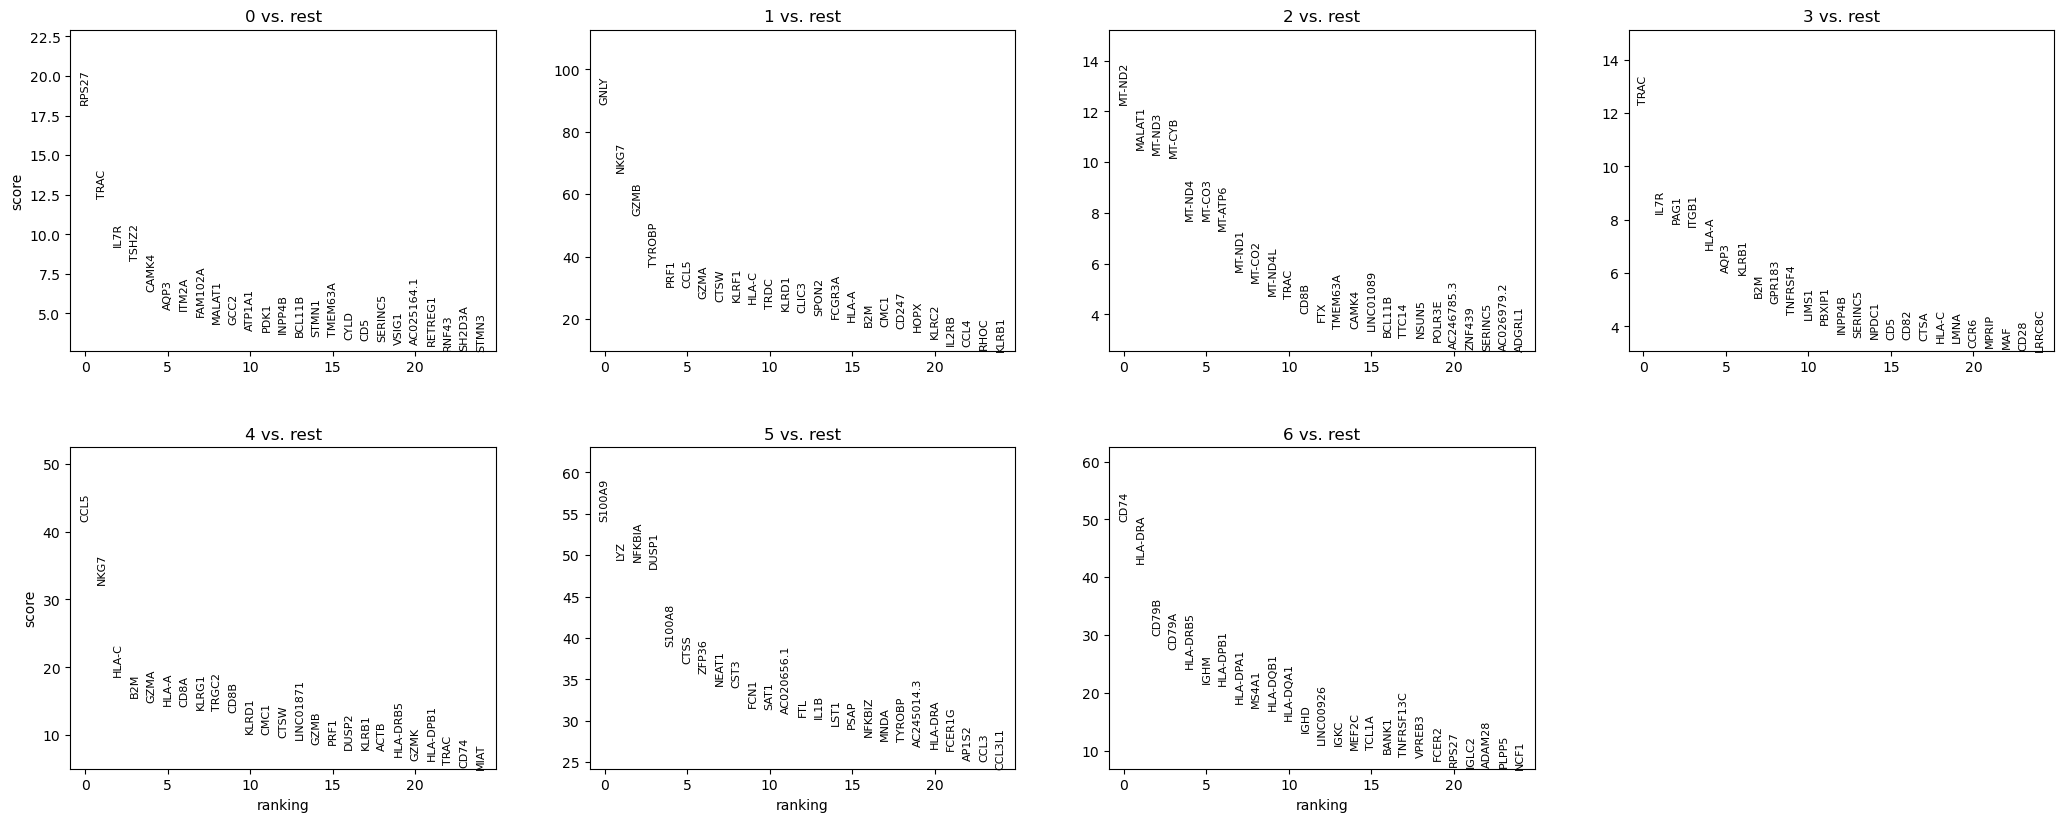

In [9]:
sc.tl.louvain(adata)

# Differential expression analysis  t-test
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')

# Results
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [11]:
result = adata.uns['rank_genes_groups']
result

{'params': {'groupby': 'louvain',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('RPS27', 'GNLY', 'MT-ND2', 'TRAC', 'CCL5', 'S100A9', 'CD74'),
            ('TRAC', 'NKG7', 'MALAT1', 'IL7R', 'NKG7', 'LYZ', 'HLA-DRA'),
            ('IL7R', 'GZMB', 'MT-ND3', 'PAG1', 'HLA-C', 'NFKBIA', 'CD79B'),
            ...,
            ('CCL5', 'NCF1', 'GZMA', 'KLRD1', 'TXK', 'GZMA', 'BCL11B'),
            ('HLA-DRB5', 'IL7R', 'NKG7', 'TYROBP', 'TSHZ2', 'IL7R', 'TRAC'),
            ('NKG7', 'TRAC', 'HLA-DRB5', 'GZMB', 'TYROBP', 'TRAC', 'IL7R')],
           dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O')]),
 'scores': rec.array([( 18.246962,  88.95923 ,  12.300828,  12.348691 ,  41.516144,  54.07147 ,  49.624367),
            ( 12.26566 ,  66.99556 ,  10.500802,   8.239428 ,  32.314877,  49.55476 ,  42.3416  ),
            (  9.238128,  53.162815,  10.294817,   7.878

In [8]:
print(adata.X[:5, :5])

[[-0.38654051 -0.18354455 -0.08087566 -0.26722945 -0.05865811]
 [-0.38654051 -0.18354455 -0.08087566 -0.26722945 -0.05865811]
 [-0.38654051 -0.18354455 -0.08087566 -0.26722945 -0.05865811]
 [ 1.89357649 -0.18354455 -0.08087566  4.23718525 -0.05865811]
 [-0.38654051 -0.18354455 -0.08087566 -0.26722945 -0.05865811]]


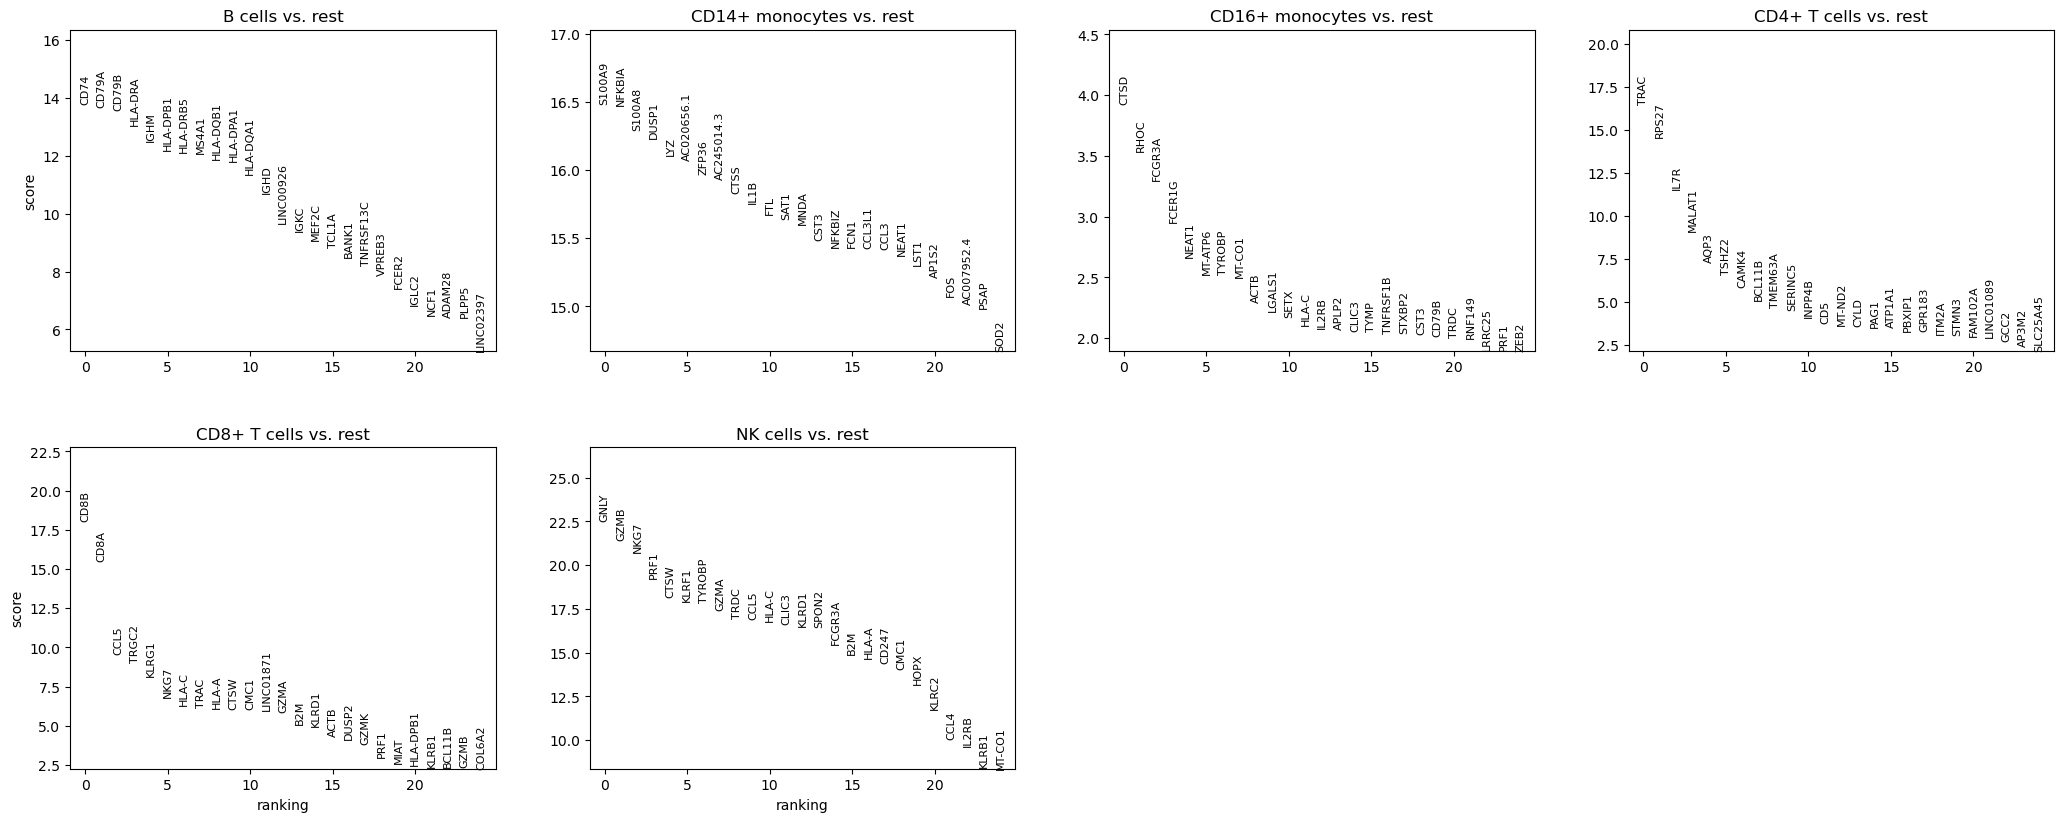

In [20]:
# Differential expression analysis  wilcoxon
sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [21]:
print(adata.obs['clusters'].value_counts())

CD4+ T cells       571
CD8+ T cells       223
NK cells           213
CD14+ monocytes     99
B cells             69
CD16+ monocytes      7
Name: clusters, dtype: int64


In [22]:
# Significantly differentially expressed genes
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
# check logfoldchanges
print(result)

{'params': {'groupby': 'clusters', 'reference': 'rest', 'method': 'wilcoxon', 'use_raw': True, 'layer': None, 'corr_method': 'benjamini-hochberg'}, 'names': rec.array([('CD74', 'S100A9', 'CTSD', 'TRAC', 'CD8B', 'GNLY'),
           ('CD79A', 'NFKBIA', 'RHOC', 'RPS27', 'CD8A', 'GZMB'),
           ('CD79B', 'S100A8', 'FCGR3A', 'IL7R', 'CCL5', 'NKG7'), ...,
           ('MALAT1', 'TRAC', 'IL7R', 'CCL5', 'NFKBIA', 'IL7R'),
           ('TRAC', 'RPS27', 'TRAC', 'CD74', 'NPC2', 'RPS27'),
           ('B2M', 'MALAT1', 'RPS27', 'NKG7', 'TYROBP', 'TRAC')],
          dtype=[('B cells', 'O'), ('CD14+ monocytes', 'O'), ('CD16+ monocytes', 'O'), ('CD4+ T cells', 'O'), ('CD8+ T cells', 'O'), ('NK cells', 'O')]), 'scores': rec.array([(13.801243 ,  16.487066 ,  3.9296105,  16.514946 , 18.025549,  22.493467),
           (13.671314 ,  16.479376 ,  3.5364828,  14.56998  , 15.49059 ,  21.431904),
           (13.57882  ,  16.290056 ,  3.3032715,  11.5453205,  9.592202,  20.750095),
           ...,
           (

In [40]:
bubble_data = []
top_n_genes = 10  # top10
for group in groups:
    names = result['names'][group][:top_n_genes]
    pvals = result['pvals'][group][:top_n_genes]
    logfc = result['logfoldchanges'][group][:top_n_genes]
    for gene, pval, fc in zip(names, pvals, logfc):
        bubble_data.append([group, gene, -np.log10(pval), fc])
bubble_df = pd.DataFrame(bubble_data, columns=['Cluster', 'Gene', '-log10(pval)', 'LogFC'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


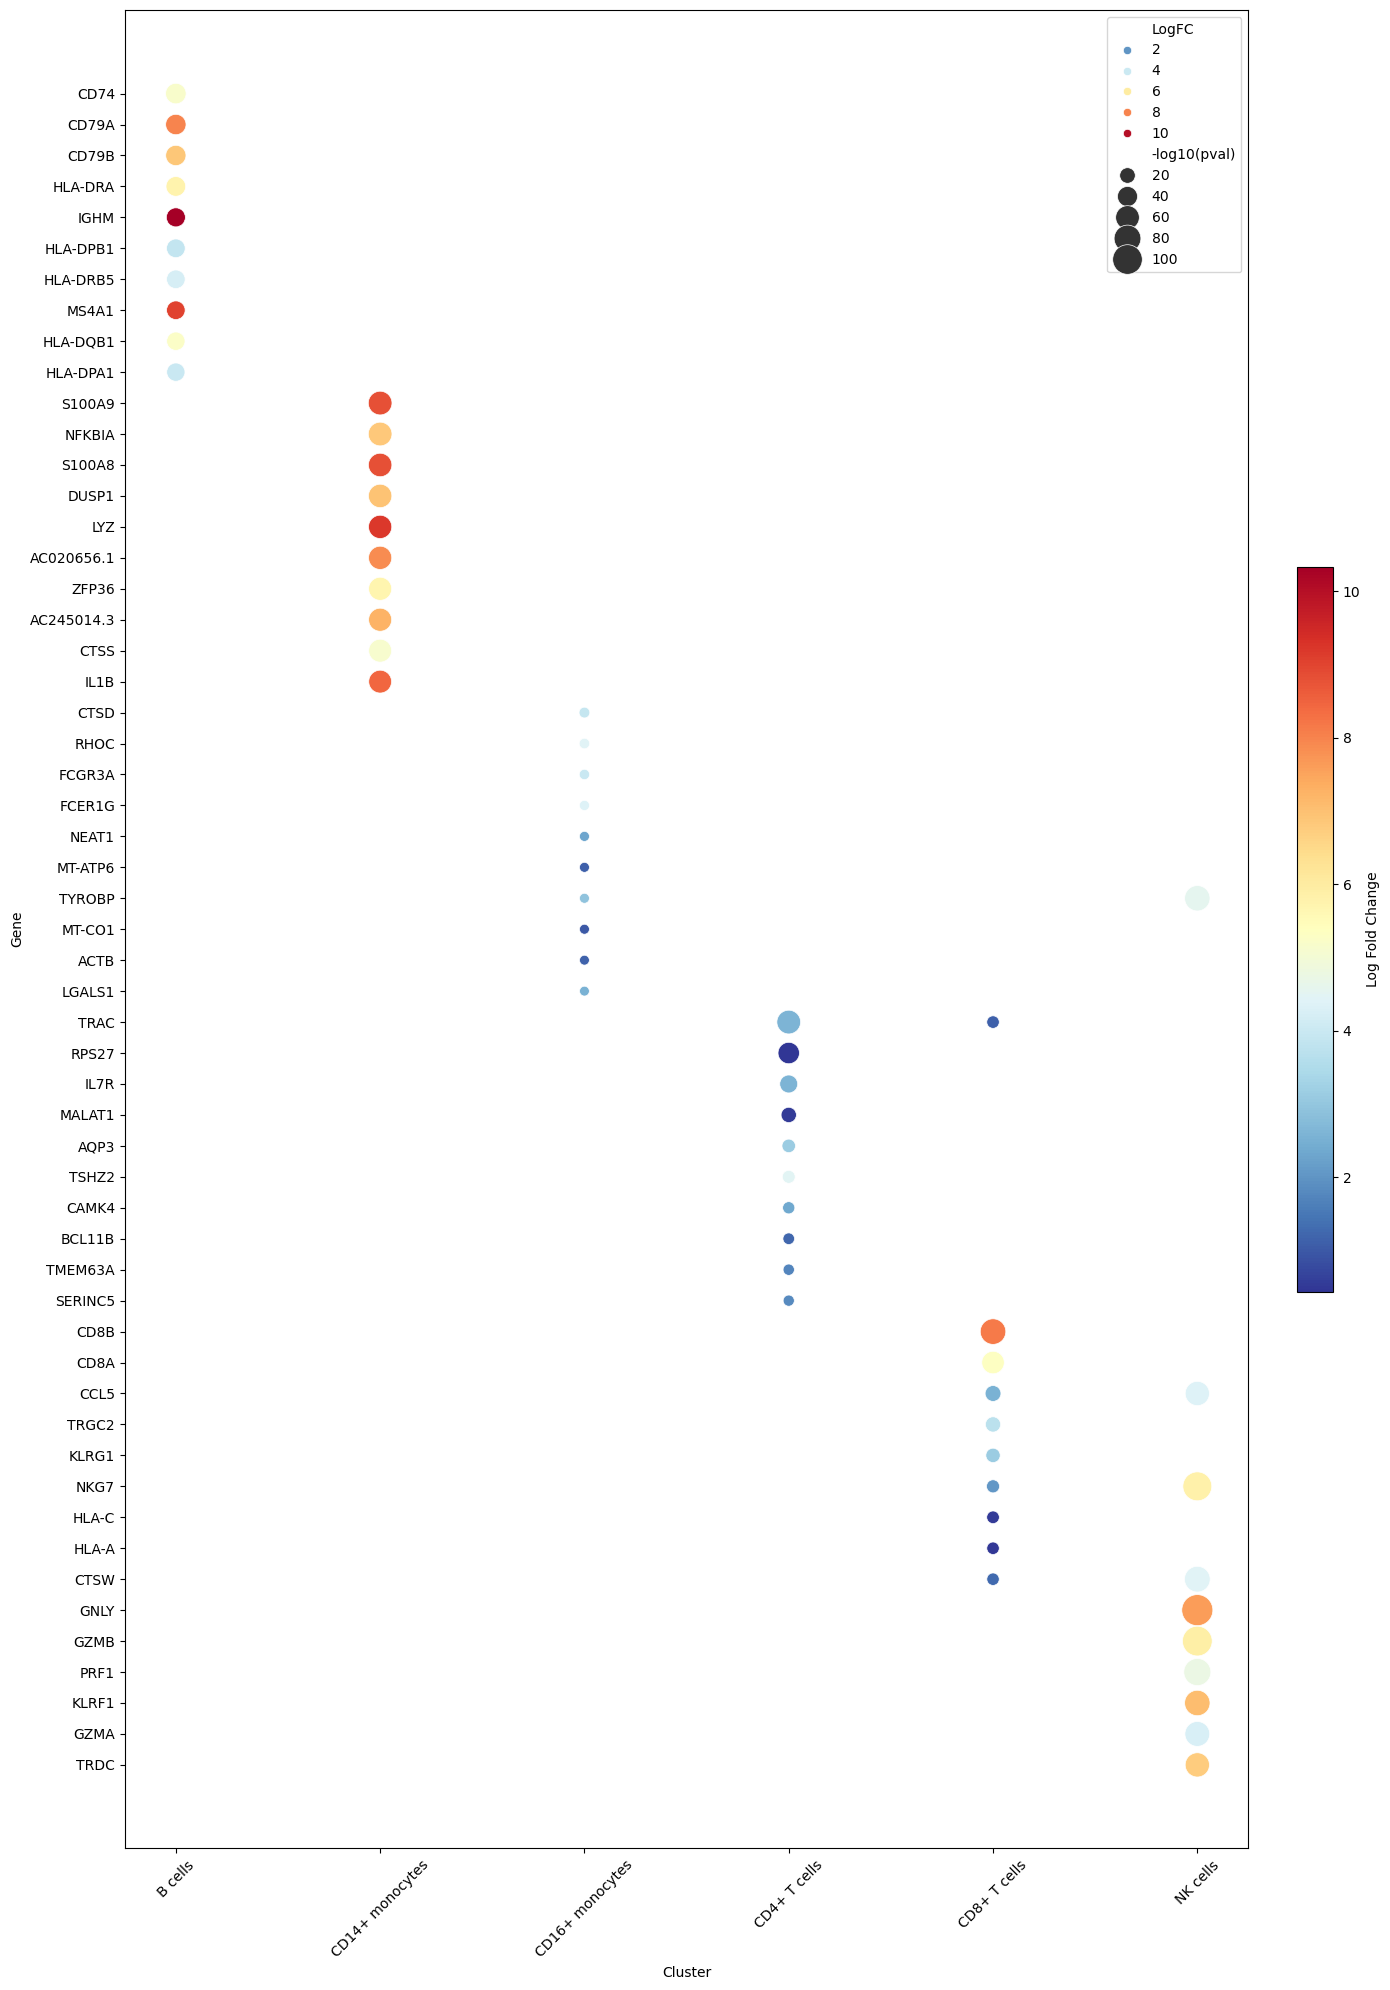

In [45]:
plt.figure(figsize=(14, 20))
scatter = sns.scatterplot(data=bubble_df, x='Cluster', y='Gene', size='-log10(pval)', hue='LogFC', palette='RdYlBu_r', edgecolor='w', linewidth=0.5, sizes=(50, 500))

norm = plt.Normalize(bubble_df['LogFC'].min(), bubble_df['LogFC'].max())
sm = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=norm)
sm.set_array([])
cbar = scatter.figure.colorbar(sm, ax=scatter, fraction=0.03, pad=0.04)
cbar.set_label('Log Fold Change')

plt.xlabel('Cluster')
plt.ylabel('Gene')
plt.title('')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('differential_gene_expression_bubble_plot.eps', format='eps')
plt.show()

In [50]:
deg_dfs = {}
for group in groups:
    deg_df = pd.DataFrame({
        'gene': result['names'][group],
        'log2FoldChange': result['logfoldchanges'][group],
        'pvals_adj': result['pvals_adj'][group]
    }).dropna()
    deg_dfs[group] = deg_df
deg_dfs

{'B cells':          gene  log2FoldChange     pvals_adj
 0        CD74        5.165538  5.009949e-40
 1       CD79A        7.981930  1.506485e-39
 2       CD79B        6.859628  3.565376e-39
 3     HLA-DRA        5.761605  2.328898e-36
 4        IGHM       10.335385  2.604340e-33
 ...       ...             ...           ...
 1995     NKG7       -4.919409  1.790770e-05
 1996    HLA-A       -0.845049  1.674567e-09
 1997   MALAT1       -0.546402  1.062034e-09
 1998     TRAC       -4.412708  3.990973e-13
 1999      B2M       -0.836954  5.585753e-18
 
 [2000 rows x 3 columns],
 'CD14+ monocytes':         gene  log2FoldChange     pvals_adj
 0     S100A9        8.814350  5.161479e-58
 1     NFKBIA        6.849723  5.161479e-58
 2     S100A8        8.795562  7.741407e-57
 3      DUSP1        6.956934  1.480897e-56
 4        LYZ        9.209616  8.642719e-56
 ...      ...             ...           ...
 1995   HLA-C       -0.918961  1.590771e-09
 1996   HLA-A       -1.302402  2.173662e-20
 1997 

In [15]:
# GSEA
enrich_results = {}
for group, deg_df in deg_dfs.items():
    gene_list = deg_df['gene'].tolist()
    print(f"Group: {group}, Number of genes: {len(gene_list)}")
    
    if len(gene_list) > 0:
        enr = gp.enrichr(gene_list=gene_list,
                         gene_sets='KEGG_2016',
                         organism='Human', # or 'Mouse'
                         outdir=None,
                         cutoff=0.05)  # Adjust p-value
        enrich_results[group] = enr.results
    else:
        enrich_results[group] = pd.DataFrame()




Group: 0, Number of genes: 2000
Group: 1, Number of genes: 2000
Group: 2, Number of genes: 2000
Group: 3, Number of genes: 2000
Group: 4, Number of genes: 2000
Group: 5, Number of genes: 2000
Group: 6, Number of genes: 2000


<Axes: title={'center': '1 KEGG_2016 Enrichment'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

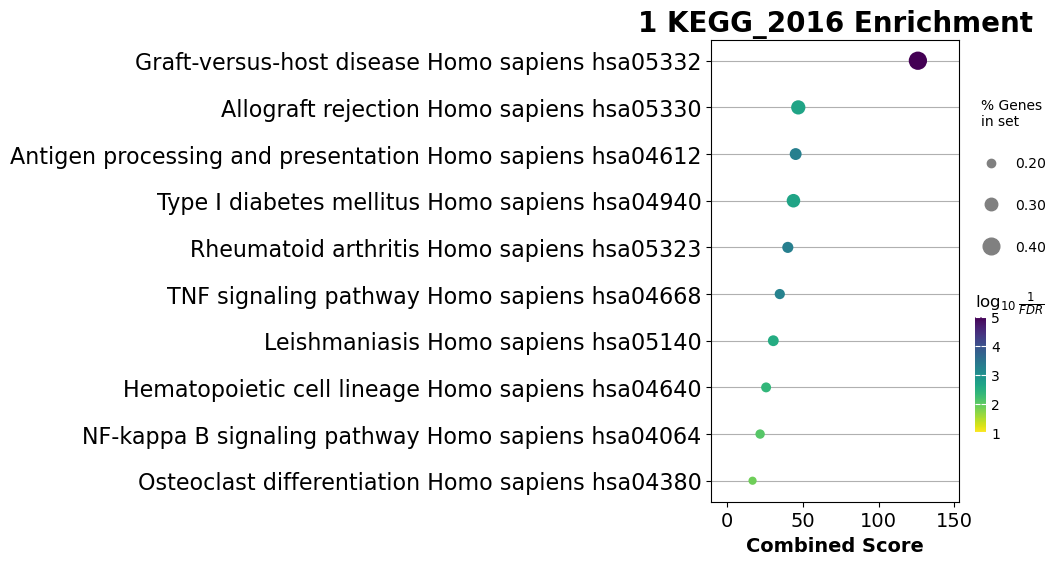

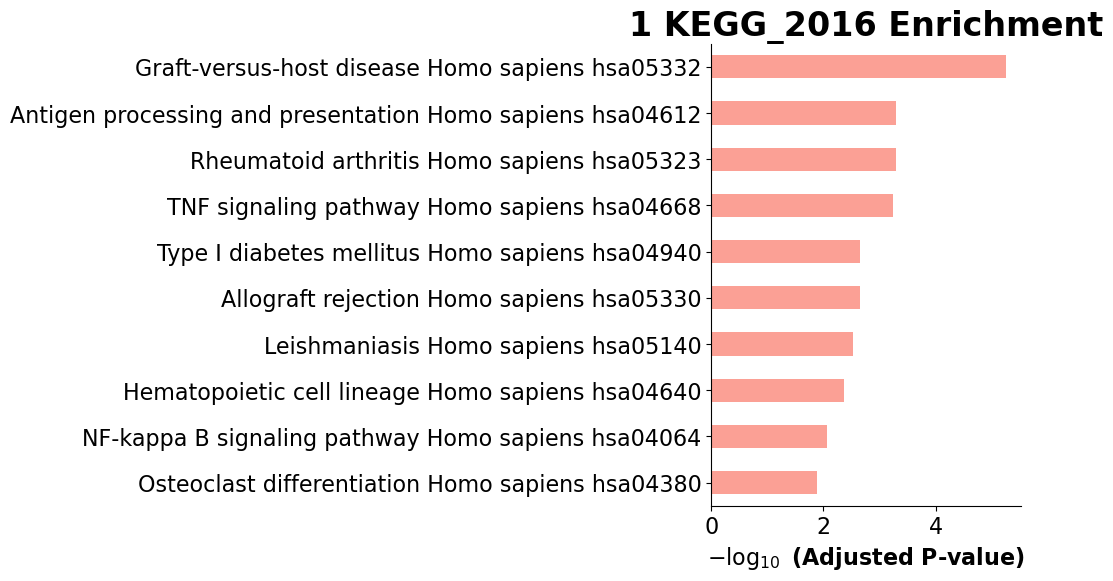

In [17]:
group = "1"
dotplot(enrich_results[group], title=f'{group} KEGG_2016 Enrichment', cmap='viridis_r')
barplot(enrich_results[group], title=f'{group} KEGG_2016 Enrichment')

In [55]:
enrich_results = {}
for cluster, deg_df in deg_dfs.items():
    gene_list = deg_df['gene'].tolist()
    enr = gp.enrichr(gene_list=gene_list,
                     gene_sets='MSigDB_Hallmark_2020',
                     organism='Human',
                     outdir=None)
    enrich_results[cluster] = enr.res2d.set_index('Term')['Combined Score']

enrich_df = pd.DataFrame(enrich_results).fillna(0)
enrich_df

,B cells,CD14+ monocytes,CD16+ monocytes,CD4+ T cells,CD8+ T cells,NK cells
Term,,,,,,
TNF-alpha Signaling via NF-kB,1.162631e+02,1.162631e+02,1.162631e+02,1.162631e+02,1.162631e+02,1.162631e+02
Interferon Gamma Response,2.524278e+01,2.524278e+01,2.524278e+01,2.524278e+01,2.524278e+01,2.524278e+01
IL-2/STAT5 Signaling,1.821626e+01,1.821626e+01,1.821626e+01,1.821626e+01,1.821626e+01,1.821626e+01
Inflammatory Response,1.788644e+01,1.788644e+01,1.788644e+01,1.788644e+01,1.788644e+01,1.788644e+01
IL-6/JAK/STAT3 Signaling,2.192337e+01,2.192337e+01,2.192337e+01,2.192337e+01,2.192337e+01,2.192337e+01
Allograft Rejection,1.388865e+01,1.388865e+01,1.388865e+01,1.388865e+01,1.388865e+01,1.388865e+01
KRAS Signaling Up,1.054361e+01,1.054361e+01,1.054361e+01,1.054361e+01,1.054361e+01,1.054361e+01
Interferon Alpha Response,1.017266e+01,1.017266e+01,1.017266e+01,1.017266e+01,1.017266e+01,1.017266e+01
Mitotic Spindle,6.762772e+00,6.762772e+00,6.762772e+00,6.762772e+00,6.762772e+00,6.762772e+00


D:\Anaconda\Lib\site-packages\seaborn\matrix.py:623: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


<Figure size 1400x2000 with 0 Axes>

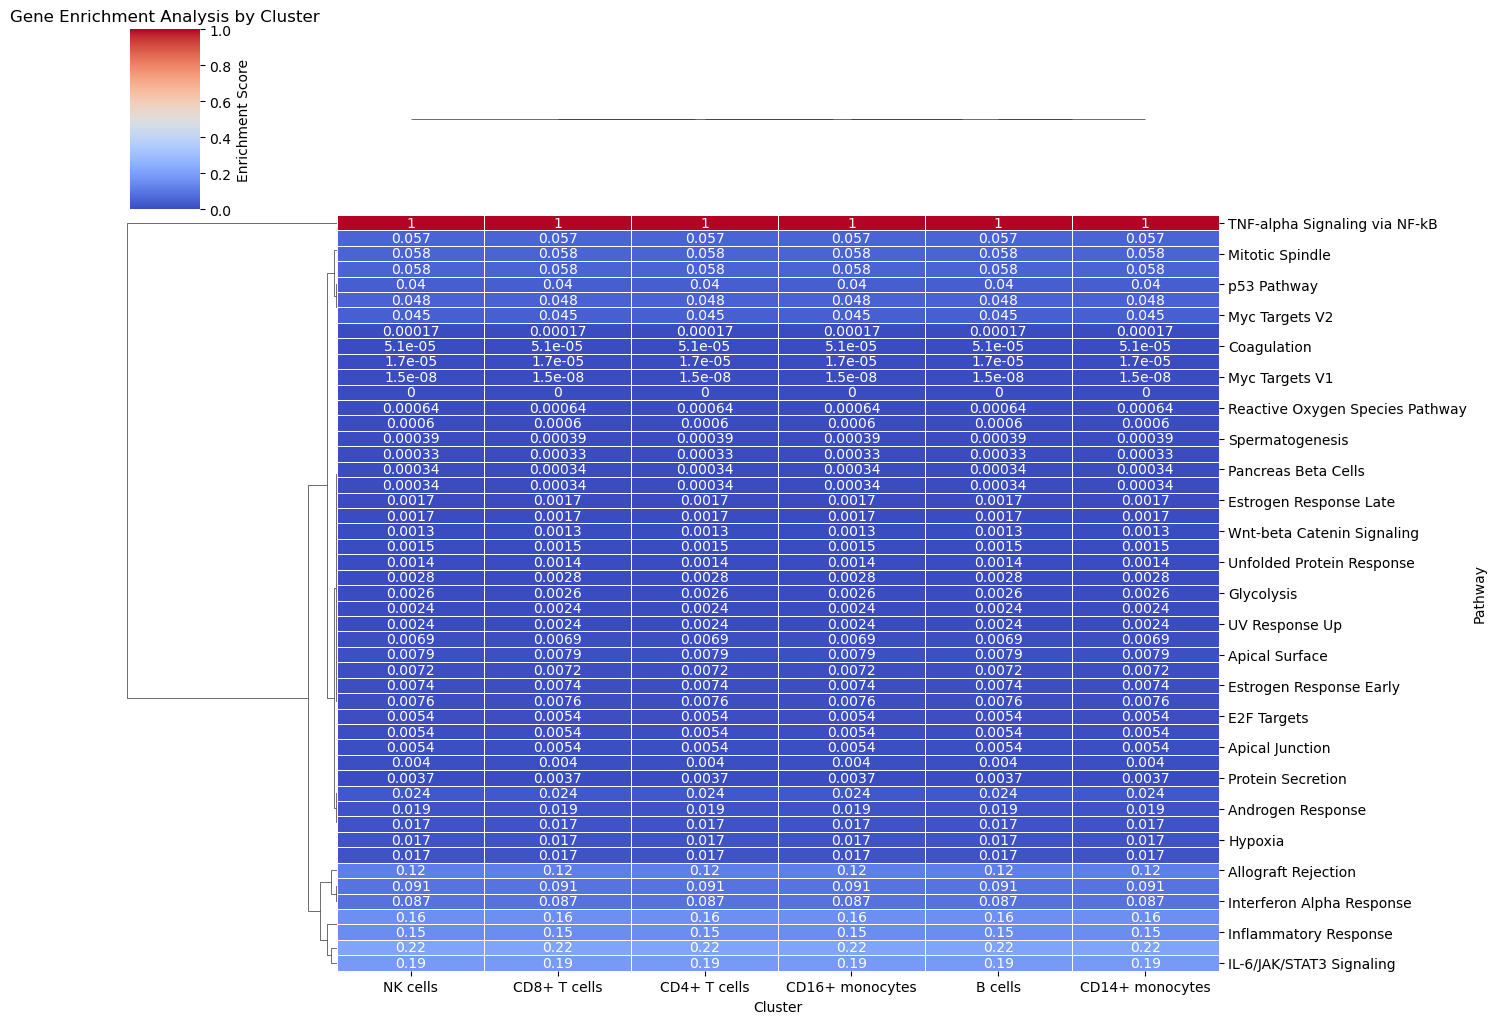

In [56]:
enrich_df = pd.DataFrame(enrich_results).fillna(0)

plt.figure(figsize=(14, 20))
g = sns.clustermap(enrich_df, cmap="coolwarm", standard_scale=1, linewidths=0.5, figsize=(14, 10), annot=True, cbar_kws={'label': 'Enrichment Score'})

g.ax_heatmap.set_xlabel('Cluster')
g.ax_heatmap.set_ylabel('Pathway')
plt.title('Gene Enrichment Analysis by Cluster')
plt.savefig('gene_enrichment_analysis_clustermap.eps', format='eps')
plt.show()

In [71]:
for group in groups:
    deg_df = pd.DataFrame({
        'gene': result['names'][group][:top_n_genes],
        'log2FoldChange': result['logfoldchanges'][group][:top_n_genes],
        'pvals_adj': result['pvals_adj'][group][:top_n_genes]
    }).dropna()
    deg_dfs[group] = deg_df
deg_dfs

{'B cells':        gene  log2FoldChange     pvals_adj
 0      CD74        5.165538  5.009949e-40
 1     CD79A        7.981930  1.506485e-39
 2     CD79B        6.859628  3.565376e-39
 3   HLA-DRA        5.761605  2.328898e-36
 4      IGHM       10.335385  2.604340e-33
 5  HLA-DPB1        3.846307  9.148750e-32
 6  HLA-DRB5        4.221369  2.595413e-31
 7     MS4A1        9.021924  2.622620e-31
 8  HLA-DQB1        5.258143  2.909169e-30
 9  HLA-DPA1        3.966182  6.075823e-30,
 'CD14+ monocytes':          gene  log2FoldChange     pvals_adj
 0      S100A9        8.814350  5.161479e-58
 1      NFKBIA        6.849723  5.161479e-58
 2      S100A8        8.795562  7.741407e-57
 3       DUSP1        6.956934  1.480897e-56
 4         LYZ        9.209616  8.642719e-56
 5  AC020656.1        7.888522  1.327011e-55
 6       ZFP36        5.732012  6.069251e-55
 7  AC245014.3        7.256781  9.426229e-55
 8        CTSS        5.130956  4.438875e-54
 9        IL1B        8.465908  1.173911e-53,


<Figure size 1400x1000 with 0 Axes>

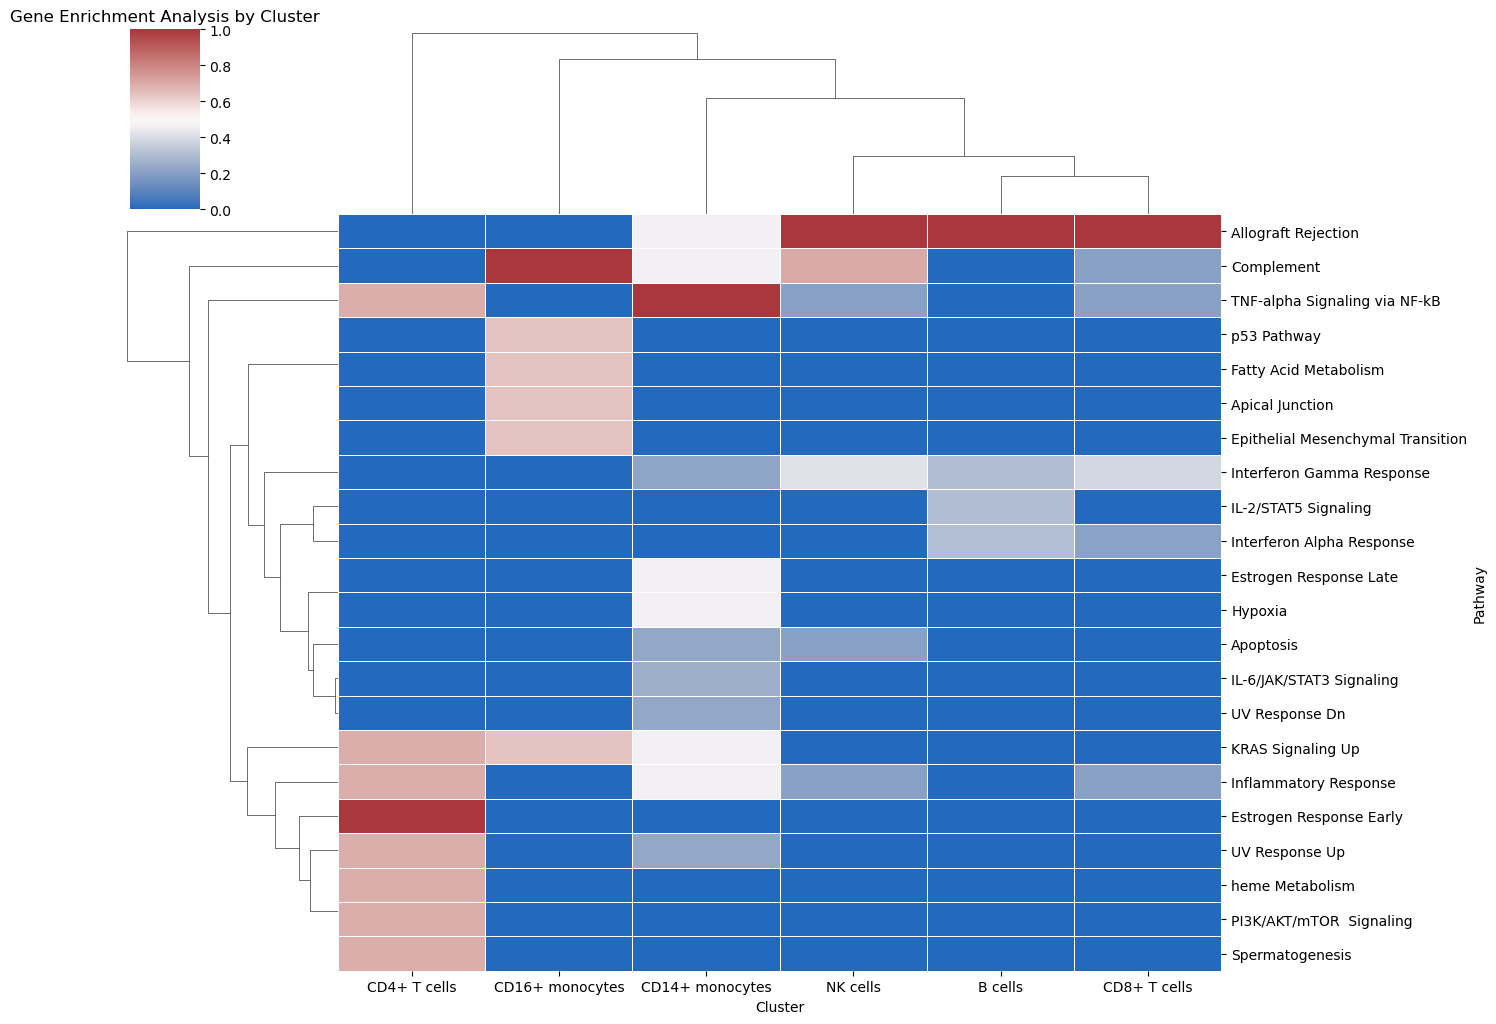

In [130]:
enrich_results = {}
for cluster, deg_df in deg_dfs.items():
    gene_list = deg_df['gene'].tolist()
    enr = gp.enrichr(gene_list=gene_list,
                     gene_sets='MSigDB_Hallmark_2020',
                     organism='Human',
                     outdir=None)
    enrich_results[cluster] = -np.log10(enr.res2d.set_index('Term')['Adjusted P-value'])


enrich_df = pd.DataFrame(enrich_results).fillna(0)


plt.figure(figsize=(14, 10))
g = sns.clustermap(enrich_df, cmap="vlag", standard_scale=1, linewidths=0.5, figsize=(14, 10), annot=False)


g.ax_heatmap.set_xlabel('Cluster')
g.ax_heatmap.set_ylabel('Pathway')
plt.title('Gene Enrichment Analysis by Cluster')
plt.savefig('gene_enrichment_analysis_clustermap.eps', format='eps')
plt.show()

<Figure size 1200x1200 with 0 Axes>

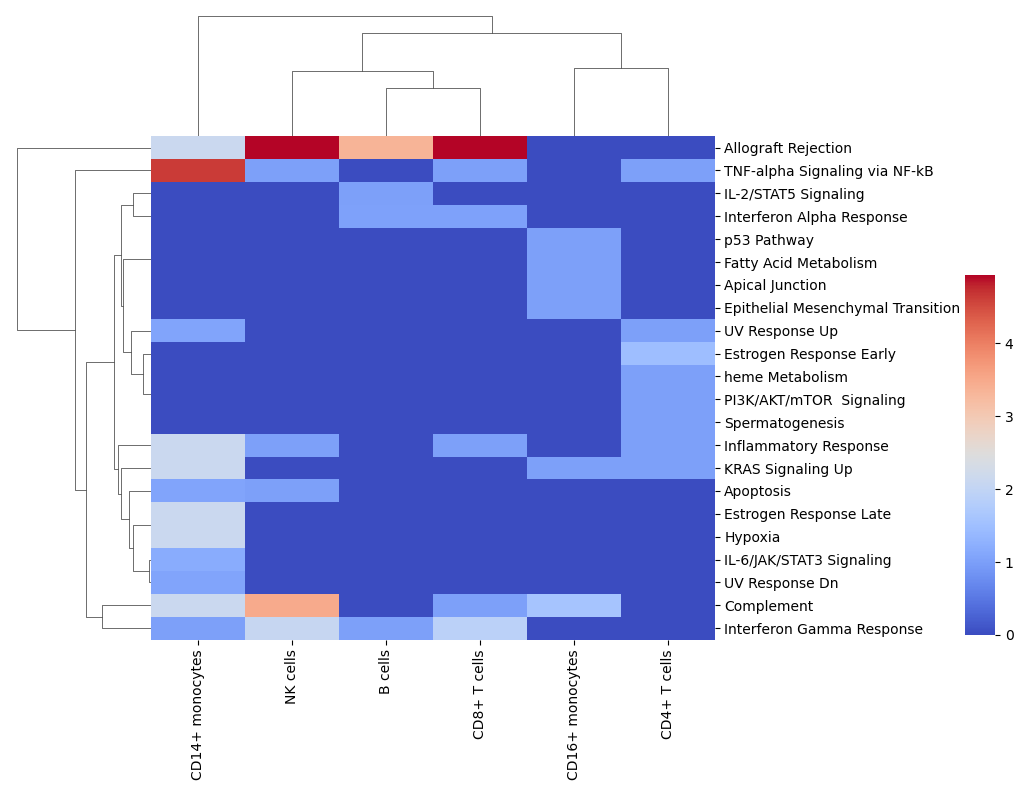

In [102]:
colors = ["#BD6263","#8EA325","#A9D179","#84CAC0","#F5AE6B","#BCB8D3","#4387B5"] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
plt.figure(figsize=(12, 12))


g = sns.clustermap(enrich_df, cmap='vlag', figsize=(10, 8),
                   square=True)  # square=True

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), rotation=0)


plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)


g.ax_row_dendrogram.set_visible(True)
g.ax_col_dendrogram.set_visible(True)

g.cax.set_visible(True)
g.cax.set_position([0.97, 0.2, 0.03, 0.45])

plt.savefig("adjusted_clustermap.png")
plt.show()

<Figure size 1400x1000 with 0 Axes>

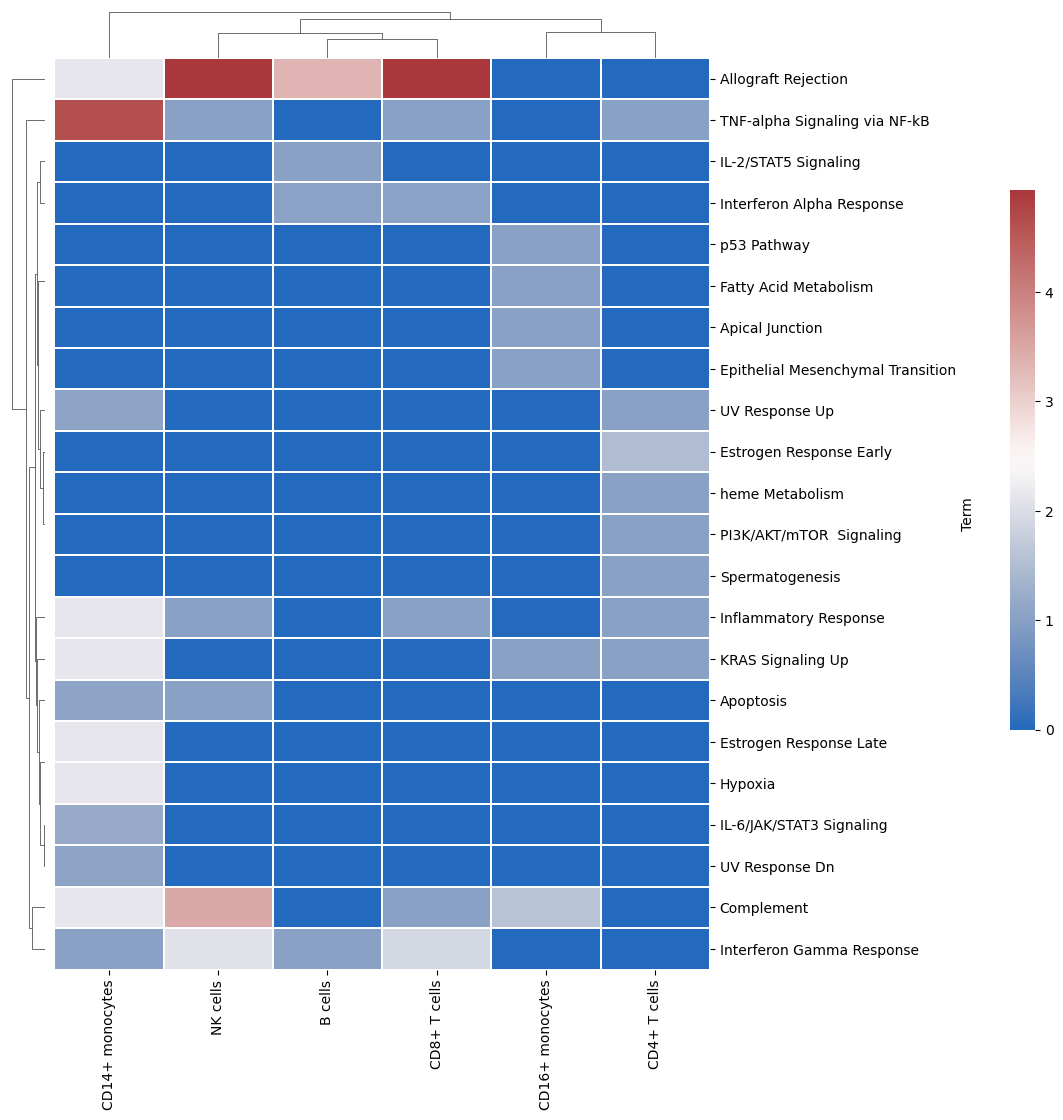

In [131]:
colors = ["#add8e6", "#ffff00", "#ff6347"]
cmap_name = "custom_cmap"
n_bins = 100
vmin, vmax = -2, 3

cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
plt.figure(figsize=(14, 10))
g = sns.clustermap(enrich_df, cmap='vlag', figsize=(10, 12),                   
                   linewidths=0.1,
                   dendrogram_ratio=(0.05, 0.05),
                   vmin=vmin, vmax=vmax
                   )

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)


plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
g.cax.set_visible(True)
g.cax.set_position([1.1, 0.3, 0.025, 0.45])
plt.title('')
plt.savefig('gene_enrichment_analysis_clustermap.eps', format='eps')
plt.show()